# Style Transfer

**Mount Google drive to load images**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
import torch
import torch.optim as optim
from torchvision import transforms, models
import requests

**Load VGG19 pretrained model**

In [3]:
# get features part of vgg19 by excluding classifier part
vgg = models.vgg19(pretrained=True).features

# Terminate backpropogation for all vgg parameters
for para in vgg.parameters():
    para.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:23, 24865005.49it/s]


**Loading VGG19 model into cuda(GPU)**

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [0]:
def load_image(img_path, max_size=400, shape=None):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
        
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])
    
    # discard transparent and alpha channel
    image = transform(image)[:3,:,:].unsqueeze(0)
    
    return image

**Load content and style image**

In [0]:
# content image
content = load_image('/content/gdrive/My Drive/dataset/style_transfer/octopus.jpg').to(device)
# style image
style = load_image('/content/gdrive/My Drive/dataset/style_transfer/delaunay.jpg',shape=content.shape[-2:]).to(device)

**Convert tensor into numpy array**

In [0]:
def convert_tensor_image(tensor):
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image= image.clip(0,1)
    return image

**Display images**

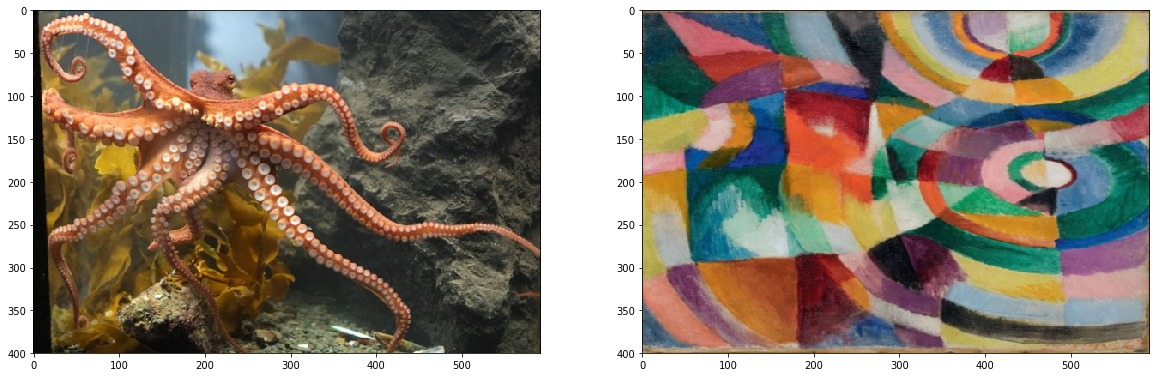

In [8]:
fig, (img1, img2) = plt.subplots(1,2,figsize=(20,10))
img1.imshow(convert_tensor_image(content))
img2.imshow(convert_tensor_image(style))

**Extract content and style features from image**

In [0]:
def get_features(image, model, layers=None):
    # layers for content and style representation of image
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',    # content representation of image
            '28': 'conv5_1'
        }
    features = dict()
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

**Gram matrix**

In [0]:
def gram_matrix(tensor):
    _, d, h,w = tensor.size()
    # reshape the feature map into depth and height * weight
    tensor = tensor.view(d, h * w)
    # matrix multiplication between vectorized feature maps and transpose of it.
    gram = torch.mm(tensor, tensor.t())
    return gram

**putting all together**

In [0]:
# extract content feature from content image
content_features = get_features(content, vgg)

# extract style feature from style image
style_features = get_features(style, vgg)

# gram matrices for all style features layer
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# creating target image from content image
target = content.clone().requires_grad_(True).to(device)

In [0]:
# style layers weights
style_weights = {'conv1_1':1., 'conv2_1':0.75, 'conv3_1':0.2, 'conv4_1':0.2, 'conv5_1':0.2}

# content weight and style weight for total loss
content_weight = 1
style_weight = 1e6

Total loss 2135326.25


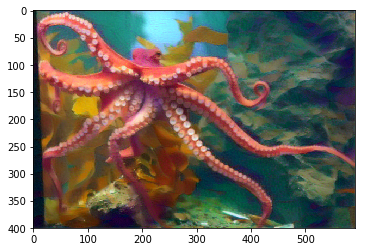

Total loss 964993.6875


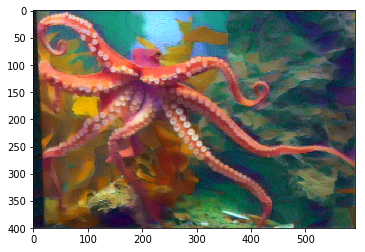

Total loss 609185.1875


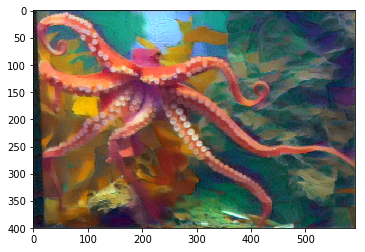

Total loss 424569.8125


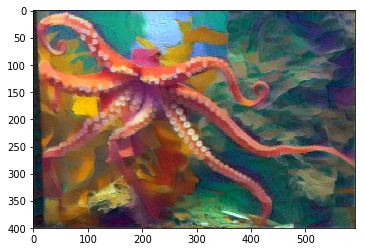

In [13]:
# optimizer for optimize target image
optimizer = optim.Adam([target], lr=0.003)

steps = 2000 # iterations to update target image
for ii in range(1, steps+1):
    target_features = get_features(target, vgg)
    
    # content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0
    # calculate style loss for  style layers
    for layer in style_weights:
        # get layer
        target_feature = target_features[layer]
        # get gram matrix for layer of style layers
        target_gram = gram_matrix(target_feature)
        # extract dimensions from target image
        _, d, h, w = target_feature.shape
        # corresponding layer in style layers
        style_gram = style_grams[layer]
        # loss for style layer
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        # add loss of all layer
        style_loss += layer_style_loss / (d*h*w) # average error for complete layer
    # calculate total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update target weights
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images
    if ii % 500 == 0:
        print('Total loss', total_loss.item())
        plt.imshow(convert_tensor_image(target))
        plt.show()

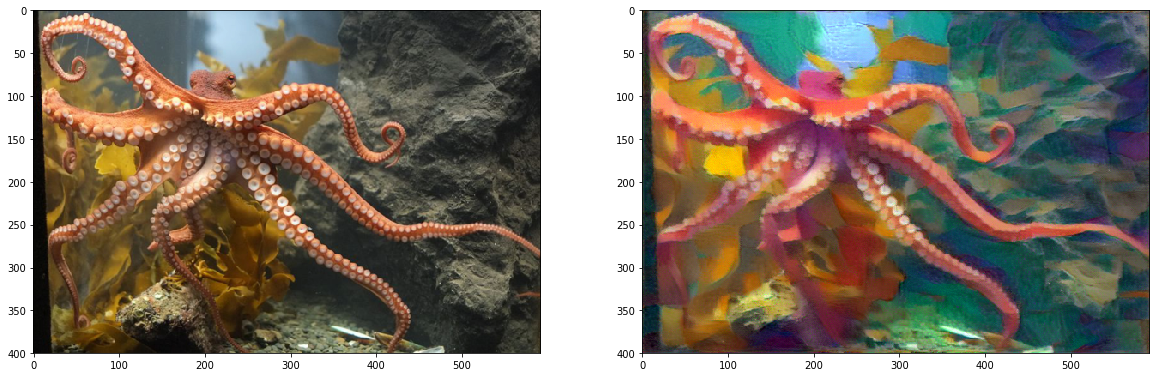

In [15]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(convert_tensor_image(content))
ax2.imshow(convert_tensor_image(target))